<a href="https://colab.research.google.com/github/osamja/zero-to-hero/blob/main/lecture_3/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [204]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

- Cheatsheet: https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part2_mlp.ipynb


In [46]:
# !wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt    # Uncomment to download names.txt
names = open('names.txt', 'r').read().splitlines()

In [47]:
# Create a dictionary of characters and their indices
chars = sorted(list(set(''.join(names))))
char2idx = {c: i+1 for i, c in enumerate(chars)}
idx2char = {i+1: c for i, c in enumerate(chars)}

char2idx['.'] = 0  # ? andrej has this set to zero but doesn't that replace the first character in the alphabet?
idx2char[0] = '.'

In [48]:
# Build the dataset
block_size = 3 # context length: how many characters to consider before predicting the next character
X, Y = [], []

for name in names[:1]:
    name = name + '.'
    context = [0] * block_size      # The first context is a block of zeros which enables padding
    for c in name:
        X.append(context)
        Y.append(char2idx[c])      # The next character is context[-1] (the last character in the context)
        # print(''.join([idx2char[i] for i in context]), '->', c)
        context = context[1:] + [char2idx[c]]   # Crop & shift the context by one character
        
X = torch.tensor(X, dtype=torch.long)   # Should we be using long or ints?
Y = torch.tensor(Y, dtype=torch.long)

num_examples = X.shape[0]
print('Number of examples:', num_examples)

Number of examples: 5


In [49]:
# Embed the characters
x_enc = torch.nn.functional.one_hot(X, num_classes=27).float()
x_enc.shape

C = torch.randn((27, 2))    # Two dimensional embedding
C[5] == F.one_hot(torch.tensor(5), num_classes=27).float() @ C


tensor([True, True])

In [50]:
# wow this array indexing is so cool
emb = C[X]
emb.shape

torch.Size([5, 3, 2])

In [51]:
emb[2][2]

tensor([-0.7234, -0.9802])

In [52]:
# construct the hidden layer
W1 = torch.randn(6, 100)
b1 = torch.randn(100)

In [53]:
res = emb.reshape(5, 6)
res

tensor([[-1.4922,  0.0522, -1.4922,  0.0522, -1.4922,  0.0522],
        [-1.4922,  0.0522, -1.4922,  0.0522, -1.6107,  1.1115],
        [-1.4922,  0.0522, -1.6107,  1.1115, -0.7234, -0.9802],
        [-1.6107,  1.1115, -0.7234, -0.9802, -0.7234, -0.9802],
        [-0.7234, -0.9802, -0.7234, -0.9802, -2.3375,  0.0041]])

In [54]:
emb.view(5, 6)

tensor([[-1.4922,  0.0522, -1.4922,  0.0522, -1.4922,  0.0522],
        [-1.4922,  0.0522, -1.4922,  0.0522, -1.6107,  1.1115],
        [-1.4922,  0.0522, -1.6107,  1.1115, -0.7234, -0.9802],
        [-1.6107,  1.1115, -0.7234, -0.9802, -0.7234, -0.9802],
        [-0.7234, -0.9802, -0.7234, -0.9802, -2.3375,  0.0041]])

In [55]:
# -1 means "whatever is needed to make the shape work"- copilot. haha same as num_examples
emb.view(-1, 6) == emb.reshape(num_examples, 6) 

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True]])

In [56]:
# calculate the hidden layer
h = emb.view(5, 6) @ W1 + b1
h = torch.tanh(h)
h.min(), h.max()

(tensor(-1.0000), tensor(1.))

In [57]:
# create the output layer
W2 = torch.randn(100, 27)
b2 = torch.randn(27) 

logits = h @ W2 + b2

In [58]:
logits.shape

torch.Size([5, 27])

In [59]:
# Let's get our fake counts and then normalize them into a probability distribution
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape, prob.sum(1)

(torch.Size([5, 27]), tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000]))

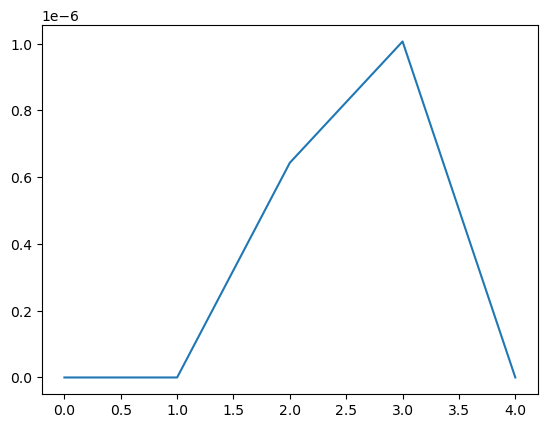

In [60]:
# Lets use y to get the actual probability
pr_dist = prob[torch.arange(num_examples), Y]
plt.plot(pr_dist)

In [61]:
# Now we can calculate the loss
loss = -torch.log(pr_dist).mean()
loss

tensor(23.3431)

In [62]:
F.cross_entropy(logits, Y)  # This is the same as the above

tensor(23.3431)

In [63]:
# Train the model from scratch
weights = None

In [64]:
 # Create a function to train the model
def train(names, weights=[], lr=0.1, epochs=1000, batch_size=32):
    loss_counts = []
    num_names = len(names)
    
    # Keep track of the learning rates
    # lre = torch.linspace(-3, 0, epochs)
    # lrs = 10 ** lre
    # learning_rates = []

    # Create a dictionary of characters and their indices
    chars = sorted(list(set(''.join(names))))
    char2idx = {c: i+1 for i, c in enumerate(chars)}
    idx2char = {i+1: c for i, c in enumerate(chars)}
    char2idx['.'] = 0  # ? andrej has this set to zero but doesn't that replace the first character in the alphabet?
    idx2char[0] = '.'

    # Build the dataset
    
    block_size = 3 # context length: how many characters to consider before predicting the next character
    X, Y = [], []

    for name in names[:num_names]:
        name = name + '.'
        context = [0] * block_size      # The first context is a block of zeros which enables padding
        for c in name:
            X.append(context)
            Y.append(char2idx[c])      # The next character is context[-1] (the last character in the context)
            # print(''.join([idx2char[i] for i in context]), '->', c)
            context = context[1:] + [char2idx[c]]   # Crop & shift the context by one character
            
    X = torch.tensor(X, dtype=torch.long)   # Should we be using long or ints?
    Y = torch.tensor(Y, dtype=torch.long)

    # Create weights if they don't exist
    if len(weights) == 0:
        # Embed the characters
        C = torch.randn((27, 2))    # Two dimensional embedding
        emb = C[X]

        # construct the hidden layer
        W1 = torch.randn(6, 100)
        b1 = torch.randn(100)

        # construct the output layer
        W2 = torch.randn(100, 27)
        b2 = torch.randn(27) 
    else:   # Otherwise use the weights that were passed in
        C, W1, b1, W2, b2 = weights

    # Set the parameters to require gradients
    parameters = [W1, b1, W2, b2, C]
    for p in parameters:
        p.requires_grad = True
    
    # Forward pass
    for epoch in range(epochs):
        # lr = lrs[epoch]
        # Get a random batch of names
        # learning_rates.append(lre[epoch])
        rand_batch_idx = torch.randint(0, num_names, (batch_size,))
        x_batch = X[rand_batch_idx]
        y_batch = Y[rand_batch_idx]

        # Embed the characters
        emb = C[x_batch]
        emb = emb.view(batch_size, 6)

        # Calculate the hidden layer
        h = torch.tanh(emb @ W1 + b1)
        logits = h @ W2 + b2

        # Calculate the loss
        loss = F.cross_entropy(logits, y_batch)
        loss_counts.append(loss.item())
        
        # Backward pass
        loss.backward()
        
        # Update the weights
        with torch.no_grad():
            W1 -= lr * W1.grad
            b1 -= lr * b1.grad
            W2 -= lr * W2.grad
            b2 -= lr * b2.grad
            C -= lr * C.grad
            
        # Zero the gradients
        W1.grad.zero_()
        b1.grad.zero_()
        W2.grad.zero_()
        b2.grad.zero_()
        C.grad.zero_()
        
        if epoch == 100 == 0:
            print(f'Epoch: {epoch}, Loss: {loss.item()}')

    # Calculate the number of parameters
    batch_parameters = [W1, b1, W2, b2, emb]
    num_parameters = 0
    for p in batch_parameters:
        for s in p.shape:
            num_parameters += s
    print('Number of parameters:', num_parameters)

    # Plot the learning rates
    # plt.plot(learning_rates, loss_counts)
    # plt.xlabel('Learning rate')
    # plt.ylabel('Loss')
    # plt.title(f'Loss over learning rate')
    # plt.show()


    # Plot the loss
    plt.plot(loss_counts)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss over time')
    plt.annotate(f'lr={lr:.3f}, batch_size={batch_size}, num_names={num_names}, min_loss={min(loss_counts):.3f}', (0, 0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top')

    # Return the trained parameter weighst
    return [C, W1, b1, W2, b2]



Number of parameters: 398


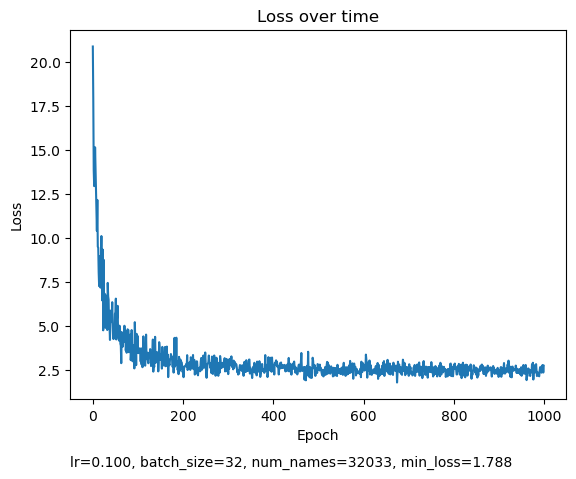

In [65]:
names = open('names.txt', 'r').read().splitlines()
weights = train(names)

Number of parameters: 398


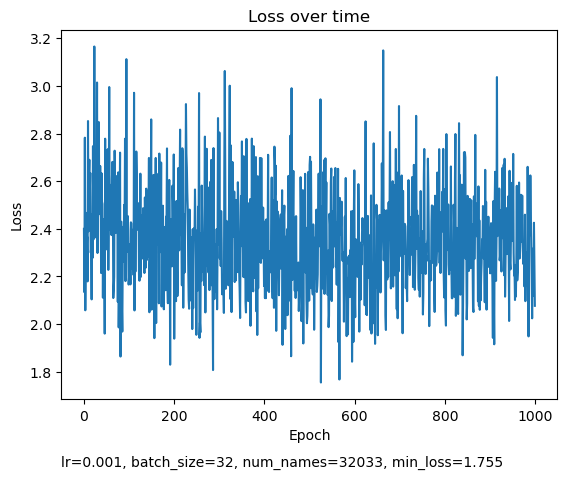

In [66]:
weights = train(names, weights=weights, lr=0.001, epochs=1000, batch_size=32)

In [67]:
[C, W1, b1, W2, b2] = weights
C.shape

torch.Size([27, 2])

In [68]:
# Sample from the model
def sample(C, W1, b1, W2, b2, num_names=10):
    context = [0] * 3
    block_size = 3
    generated_names = []
    K = 9
    layer_size = K * block_size
    for i in range(num_names):
        # Sample a name from the starting context character (.)
        context = [0] * block_size
        emb = C[context]
        name = ''
        while True:
            # Embed the characters
            emb = C[context]
            emb = emb.view(-1, layer_size)

            # Calculate the hidden layer
            h = torch.tanh(emb @ W1 + b1)
            logits = h @ W2 + b2

            # Sample from the output layer
            probs = logits.exp() / logits.exp().sum()
            idx = torch.multinomial(probs, 1)

            # Check if we're done
            if idx2char[idx.item()] == '.':
                generated_names.append(name)
                break

            # Add the character to the name
            name += (idx2char[idx.item()])

            # Update the context
            context = context[1:] + [idx.item()]
    
    return generated_names

sample(C, W1, b1, W2, b2)

RuntimeError: shape '[-1, 27]' is invalid for input of size 6

### Sample names
```
['ezyon',
 'sareroe',
 'voe',
 'japoyn',
 'belhe',
 'nna',
 'egefe',
 'calin',
 'kazec',
 'cein']
```

These names are 'name like' but I would've expected slightly better given we've traind on three context charactesr.

- To counteract a model that is overfitted to our data, we can create a train, validation/dev, and test split.

In [ ]:
# create the training, validation, and test sets
names = open('names.txt', 'r').read().splitlines()
num_names = len(names)
# shuffle the names
import random
random.shuffle(names)
num_train = int(num_names * 0.8)
num_val = int(num_names * 0.1)
num_test = num_names - num_train - num_val

train_names = names[:num_train]
val_names = names[num_train:num_train+num_val]
test_names = names[num_train+num_val:]




In [ ]:
# Train the model
weights = train(train_names, lr=0.1, epochs=1000, batch_size=32)

# Sample from the model
generated_names = sample(*weights, num_names=10)

# Print the generated names
print('Generated names:')
for name in generated_names:
    print(name)

In [ ]:
# Calculate the accuracy on the validation set
[C, W1, b1, W2, b2] = weights
correct = 0
total = 0

x,y = [], []
for name in train_names:
    # Convert the name to a tensor
    # Build the dataset
    block_size = 3 # context length: how many characters to consider before predicting the next character
    name = name + '.'
    context = [0] * block_size      # The first context is a block of zeros which enables padding

    for c in name:
        x.append(context)
        y.append(char2idx[c])      # The next character is context[-1] (the last character in the context)
        context = context[1:] + [char2idx[c]]   # Crop & shift the context by one character
            
x = torch.tensor(x, dtype=torch.long)   # Should we be using long or ints?
y = torch.tensor(y, dtype=torch.long)

# Embed the characters
emb = C[x]
emb = emb.view(-1, 6)

# Calculate the hidden layer
h = torch.tanh(emb @ W1 + b1)
logits = h @ W2 + b2

# Calculate the loss
loss = F.cross_entropy(logits, y)

print('Loss:', loss.item())

# Calculate the accuracy
probs = logits.exp() / logits.exp().sum()
idx = torch.argmax(probs, 1)

correct += (idx == y).sum().item()
total += len(y)

print('x:', x)
print('y:', y)
print('idx:', idx)


print('Accuracy:', correct / total)


Our loss for the train, validation, and test sets are so close that our model is actually underfitting.  To counteract this, we can expand our neural network to overit our model to our training data.

In [ ]:
 # Create a function to train the model
def train(names=train_names, weights=[], lr=0.1, epochs=10000, batch_size=64):
    loss_counts = []
    num_names = len(names)

    # Create a dictionary of characters and their indices
    chars = sorted(list(set(''.join(names))))
    char2idx = {c: i+1 for i, c in enumerate(chars)}
    idx2char = {i+1: c for i, c in enumerate(chars)}
    char2idx['.'] = 0
    idx2char[0] = '.'

    # Build the dataset
    block_size = 3 # context length: how many characters to consider before predicting the next character
    X, Y = [], []

    for name in names[:num_names]:
        name = name + '.'
        context = [0] * block_size      # The first context is a block of zeros which enables padding
        for c in name:
            X.append(context)
            Y.append(char2idx[c])      # The next character is context[-1] (the last character in the context)
            context = context[1:] + [char2idx[c]]   # Crop & shift the context by one character
            
    X = torch.tensor(X, dtype=torch.long)   # Should we be using long or ints?
    Y = torch.tensor(Y, dtype=torch.long)

    # Create weights if they don't exist
    if len(weights) == 0:
        # Embed the characters
        C = torch.randn((27, 2))    # Two dimensional embedding
        emb = C[X]

        # construct the hidden layer
        W1 = torch.randn(6, 1000)
        b1 = torch.randn(1000)

        # construct the output layer
        W2 = torch.randn(1000, 27)
        b2 = torch.randn(27) 
    else:   # Otherwise use the weights that were passed in
        C, W1, b1, W2, b2 = weights

    # Set the parameters to require gradients
    parameters = [W1, b1, W2, b2, C]
    for p in parameters:
        p.requires_grad = True
    
    # Forward pass
    for epoch in range(epochs):
        rand_batch_idx = torch.randint(0, num_names, (batch_size,))
        x_batch = X[rand_batch_idx]
        y_batch = Y[rand_batch_idx]

        # Embed the characters
        emb = C[x_batch]
        emb = emb.view(-1, 6)

        # Calculate the hidden layer
        h = torch.tanh(emb @ W1 + b1)
        logits = h @ W2 + b2

        # Calculate the loss
        loss = F.cross_entropy(logits, y_batch)
        loss_counts.append(loss.item())
        
        # Backward pass
        loss.backward()
        
        # Update the weights
        with torch.no_grad():
            W1 -= lr * W1.grad
            b1 -= lr * b1.grad
            W2 -= lr * W2.grad
            b2 -= lr * b2.grad
            C -= lr * C.grad
            
        # Zero the gradients
        W1.grad.zero_()
        b1.grad.zero_()
        W2.grad.zero_()
        b2.grad.zero_()
        C.grad.zero_()
        
        if epoch % 100 == 0:
            print(f'Epoch: {epoch}, Loss: {loss.item()}')

    # Plot the loss
    plt.plot(loss_counts)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss over time')
    plt.annotate(f'lr={lr:.3f}, batch_size={batch_size}, num_names={num_names}, min_loss={min(loss_counts):.3f}', (0, 0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top')

    # Return the trained parameter weighst
    return [C, W1, b1, W2, b2]

weights = train()

In [150]:
val_losses = []

# Exercises:
- E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2
- E02: I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?
- E03: Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?

### Exercise 1: 
- Tune the hyperparameters of the training to beat my best validation loss of 2.2

In [151]:
import random

names = open('names.txt', 'r').read().splitlines()
num_names = len(names)

# shuffle the names
random.shuffle(names)
num_train = int(num_names * 0.8)
num_val = int(num_names * 0.1)
num_test = num_names - num_train - num_val

# create the training, validation, and test sets
train_names = names[:num_train]
val_names = names[num_train:num_train+num_val]
test_names = names[num_train+num_val:]

In [195]:
# Create a function to train the model
# names: the names to train on
# hyperparams: a dictionary of hyperparameters
#   K: the number of characters to generate
#   neurons: the number of neurons in the hidden layer
#   block_size: the number of characters to consider before predicting the next character
#   epochs: the number of epochs to train for
#   lr: the learning rate
#   batch_size: the batch size
# weights: the weights to use for the model
def train(
    names,
    hyperparams,
    weights=[],
):
    # Unpack the hyperparameters from the dictionary
    K = hyperparams['K']
    neurons = hyperparams['neurons']
    block_size = hyperparams['block_size']
    epochs = hyperparams['epochs']
    lr = hyperparams['lr']
    batch_size = hyperparams['batch_size']

    adjustment_epoch = epochs // 2
    layer_size = K * block_size
    loss_counts = []
    num_names = len(names)
    
    print(f'K={K}, neurons={neurons}, block_size={block_size}, epochs={epochs}, lr={lr}, batch_size={batch_size}')

    # Create a dictionary of characters and their indices
    chars = sorted(list(set(''.join(names))))
    char2idx = {c: i+1 for i, c in enumerate(chars)}
    idx2char = {i+1: c for i, c in enumerate(chars)}
    char2idx['.'] = 0
    idx2char[0] = '.'

    # Build the dataset
    X, Y = [], []

    for name in names[:num_names]:
        name = name + '.'
        context = [0] * block_size      # The first context is a block of zeros which enables padding
        for c in name:
            X.append(context)
            Y.append(char2idx[c])      # The next character is context[-1] (the last character in the context)
            context = context[1:] + [char2idx[c]]   # Crop & shift the context by one character
            
    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)

    # Embed the characters
    C = torch.randn((27, K))    # Two dimensional embedding -> 3D -> 
    emb = C[X]

    # construct the first hidden layer
    W1 = torch.randn(layer_size, neurons)
    b1 = torch.randn(neurons)

    # construct the output layer
    W2 = torch.randn(neurons, 27)
    b2 = torch.randn(27) 

    # Set the parameters to require gradients
    parameters = [W1, b1, W2, b2, C]
    for p in parameters:
        p.requires_grad = True
    
    # Forward pass
    for epoch in range(epochs):
        # Tune the learning rate and batch size
        if epoch == adjustment_epoch:
            lr = lr / 10
            batch_size = batch_size * 10
            print(f'Adjusting learning rate to {lr}, batch_size={batch_size}')
        elif epoch == epochs-5000:
            lr = lr / 10
            batch_size = batch_size * 10
            print(f'Adjusting learning rate to {lr}, batch_size={batch_size}')

        rand_batch_idx = torch.randint(0, num_names, (batch_size,))
        x_batch = X[rand_batch_idx]
        y_batch = Y[rand_batch_idx]

        # Embed the characters
        emb = C[x_batch]
        emb = emb.view(-1, layer_size)

        # Calculate the first hidden layer
        h = torch.tanh(emb @ W1 + b1)
        logits = h @ W2 + b2

        # Calculate the loss
        loss = F.cross_entropy(logits, y_batch)
        loss_counts.append(loss.item())
        
        # Backward pass
        loss.backward()
        
        # Update the weights
        with torch.no_grad():
            W1 -= lr * W1.grad
            b1 -= lr * b1.grad
            W2 -= lr * W2.grad
            b2 -= lr * b2.grad
            C -= lr * C.grad
            
        # Zero the gradients
        W1.grad.zero_()
        b1.grad.zero_()
        W2.grad.zero_()
        b2.grad.zero_()
        C.grad.zero_()

    weights = [C, W1, b1, W2, b2]
    # print(f'lr={lr:.3f}, batch_size={batch_size}, num_names={num_names}, min_loss={min(loss_counts):.3f}, K={K}, neurons={neurons}, block_size={block_size}, epochs={epochs}')

    # Plot the loss
    plt.plot(loss_counts)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss over time')
    # plt.annotate(f'lr={lr:.3f}, batch_size={batch_size}, num_names={num_names}, min_loss={min(loss_counts):.3f}', (0, 0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top')

    # Return the trained parameter weighst
    return weights

In [196]:
# Evaluate the hopefully overfitted model
def evaluate(names, weights):
    C, W1, b1, W2, b2 = weights
    num_names = len(names)
    block_size = C.shape[1]
    layer_size = W1.shape[0]

    # Build the dataset
    X, Y = [], []

    for name in names[:num_names]:
        name = name + '.'
        context = [0] * block_size      # The first context is a block of zeros which enables padding
        for c in name:
            X.append(context)
            Y.append(char2idx[c])      # The next character is context[-1] (the last character in the context)
            context = context[1:] + [char2idx[c]]   # Crop & shift the context by one character
            
    X = torch.tensor(X, dtype=torch.long)   # Should we be using long or ints?
    Y = torch.tensor(Y, dtype=torch.long)
    
    # Embed the characters
    emb = C[X]
    emb = emb.view(-1, layer_size)
    h = torch.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2

    # Calculate the loss
    loss = F.cross_entropy(logits, Y)
    
    return loss.item()


K=4, neurons=800, block_size=4, epochs=50000, lr=0.1, batch_size=32
Adjusting learning rate to 0.01, batch_size=32
Adjusting learning rate to 0.001, batch_size=320


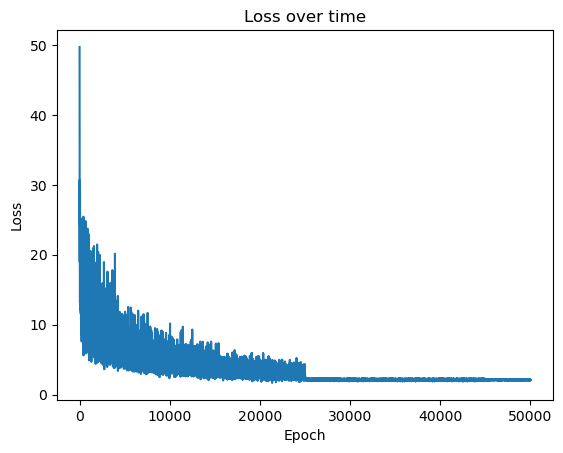

In [201]:
hyperparams = {
    'epochs':50000,
    'K': 4,
    'neurons': 800,
    'block_size': 4,
    'lr': 0.1,
    'batch_size': 32,
}

# Train the model with the best hyperparameters on the training set
weights = train(
    train_names,
    hyperparams
)

In [202]:
# Evaluate the model on the validation set
val_loss = evaluate(val_names, weights)
val_losses.append((val_loss, hyperparams))

In [203]:
for val_loss in val_losses:
    (loss, hyperparams) = val_loss
    print(f'val_loss={loss:.3f} \nhyperparams={hyperparams}\n')

val_loss=2.802 
hyperparams={'epochs': 1000, 'K': 4, 'neurons': 750, 'block_size': 4, 'lr': 0.1, 'batch_size': 32}

val_loss=3.039 
hyperparams={'epochs': 1000, 'K': 4, 'neurons': 750, 'block_size': 4, 'lr': 0.1, 'batch_size': 32}

val_loss=2.684 
hyperparams={'epochs': 1000, 'K': 4, 'neurons': 500, 'block_size': 4, 'lr': 0.1, 'batch_size': 32}

val_loss=2.418 
hyperparams={'epochs': 10000, 'K': 4, 'neurons': 500, 'block_size': 4, 'lr': 0.1, 'batch_size': 32}

val_loss=2.341 
hyperparams={'epochs': 50000, 'K': 4, 'neurons': 500, 'block_size': 4, 'lr': 0.1, 'batch_size': 32}

val_loss=2.366 
hyperparams={'epochs': 50000, 'K': 4, 'neurons': 500, 'block_size': 4, 'lr': 0.1, 'batch_size': 32}

val_loss=2.254 
hyperparams={'epochs': 50000, 'K': 4, 'neurons': 800, 'block_size': 4, 'lr': 0.1, 'batch_size': 32}



### Minimizing Validation Loss


The best I was able to do was a validation loss of 2.254 with the following hyperparams
hyperparams={'epochs': 50000, 'K': 4, 'neurons': 800, 'block_size': 4, 'lr': 0.1, 'batch_size': 32}

Although I was getting close to 2.2, I made the following enhancements to tune my validation loss
- Slowed the learning rate and increased the batch size towards the last few thousand epochs.  I could see less noise in the loss rate with this change and I figured it was what I needed for a micro-optimization to get from a loss of 2.3 to 2.2
- I tried adding another layer to the NN but that actually seemed to hurt performance.
- Instead of adding all the for loops for the various hyperparameters in the train function, I moved the hyperparams into a dictionary.  This kept the training and evaluation functions more simple which helped to debug issues.  i.e. the block_size was not defined within the function but from the notebook cells above
- Plotting the epoch vs loss graph was helpful in visualizing whether our NN was benefiting from extra epochs.  Although, I noticed that the more complex our NN was, the more epochs I needed to train over to achieve a competetive validation loss.  I tried to make it a goal to achieve a validation loss of 2.2 within 50K epochs as to create an efficient NN.


- loss.item(), K, neurons, block_size, epochs, min_loss
- (2.350400924682617, 3, 1000, 4, 50000, 1.205239176750183)
- (2.30, 3, 500, 4, 40000, 1.384570837020874)
- (2.296140193939209, 3, 800, 4, 50000, 1.3054497241973877)

In [217]:
# Sample from the model
def sample(weights, num_names=10):
    C, W1, b1, W2, b2 = weights
    block_size = C.shape[1]
    layer_size = W1.shape[0]
    context = [0] * block_size
    generated_names = []

    for i in range(num_names):
        # Sample a name from the starting context character (.)
        context = [0] * block_size
        emb = C[context]
        name = ''
        
        while True:
            # Embed the characters
            emb = C[context]
            emb = emb.view(-1, layer_size)

            # Calculate the hidden layer
            h = torch.tanh(emb @ W1 + b1)
            logits = h @ W2 + b2

            # Sample from the output layer
            probs = logits.exp() / logits.exp().sum()
            idx = torch.multinomial(probs, 1)

            # Check if we're done
            if idx2char[idx.item()] == '.':
                generated_names.append(name)
                break

            # Add the character to the name
            name += (idx2char[idx.item()])

            # Update the context
            context = context[1:] + [idx.item()]
    
    return generated_names

sample(weights)

['cabra',
 'cat',
 'zamarie',
 'amasorlynn',
 'jylon',
 'mary',
 'entriy',
 'tanrod',
 'aaknier',
 'brigeloni']

Sampled names:

```
['jeennath',
 'jassa',
 'wannyickeliah',
 'lyra',
 'delefda',
 'lyanna',
 'shuh',
 'deonne',
 'khohi',
 'binia']
 ```
 
 These names seem alright enough that I'm not going to debug this model any further :)